<a href="https://colab.research.google.com/github/IssyMiddleton/CSC8635/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd /gdrive/MyDrive/CSC8635/
## Check that the data_subjects_info.csv is in the current folder location
#@title
## set up the libraries that are needed to run the analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/MyDrive/CSC8635


Table of Content:

* Data characterization
* shape of dataset
* Missing values
* class balance
* show the first few records of each motion type
* Feature construction
* Check similiarity between time series of each motion type
* 2D visualization with the help dimension reduction: pca, tsne
* hierachical clustering with dynamic time warpping
* Predictve model
* on motion type
* on overall dataset
* model performance
* feature importance
* check correctly-predicted samples
* check incorrectly-predicted samples
* on dataset of individual motion
* on gender
* on weight


# **Introduction**

Ofcom's figures indicate that in 2020 45 percent of households in the UK have two mobile phones and published figures indicate there were over 53 million smart phones alone in the UK in May 2021 and over 2,700 million globally (statista.com, 2021). It is therefore important to understand the data they are capable of gathering about our physical activities and understand how accurate this data is. 

The dataset being reviewed is time-series data generated by accelerometer and gyroscope sensors (attitude, gravity, userAcceleration, and rotationRate). It is collected from an iPhone 6s kept in the participant's front pocket using SensingKit which collects information from Core Motion framework on iOS devices. All data collected in 50Hz sample rate. A total of 24 participants in a range of gender, age, weight, and height performed 6 activities in 15 trials in the same environment and conditions: downstairs, upstairs, walking, jogging, sitting, and standing. 

Describe work undertaken

Evaluate success

Future implications

Reflections on personal and professional development, process, technologies and methodologies - cookiecutter Data Science template in GitHub, with Git for version control, Python, Google Colab.

Detailed findings of the exploratory analysis

References:

https://www.kaggle.com/teaprint/my-analysis-on-motion-sensor-data

https://www.kaggle.com/malekzadeh/motionsense-dataset

https://www.kaggle.com/salahuddinemr/starter-motionsense-dataset-8c09b08d-5

https://www.kaggle.com/morrisb/what-does-your-smartphone-know-about-you

https://www.statista.com/statistics/387184/number-of-mobile-phones-per-household-in-the-uk/

#**Exploratory Analysis**

##**Numeric and graphical summaries**

Overview of trail participants - number, age and weight correlation, gender split, young age. Code appears to be a unique identifier and can be removed from analysis.



In [ ]:
#@title
## import the file with the data subjects details
df1 = pd.read_csv('data_subjects_info.csv', delimiter=',')
df1.dataframeName = 'data_subjects_info.csv'
nRow, nCol = df1.shape
print(f'The dimensions of the data_subjects_info.csv dataset are {nRow} rows and {nCol} columns.')

The dimensions of the data_subjects_info.csv dataset are 24 rows and 5 columns.


The first five records of the dataset look like this:

In [ ]:
df1.head(5)

,code,weight,height,age,gender
0,1,102,188,46,1
1,2,72,180,28,1
2,3,48,161,28,0
3,4,90,176,31,1
4,5,48,164,23,0


The Histograms for the data show the variation in weight, height, age and gender of the participants in the trail. The majority are under 80kg, under 165cm and under 35 years of age. Fourteen males and ten females participated.

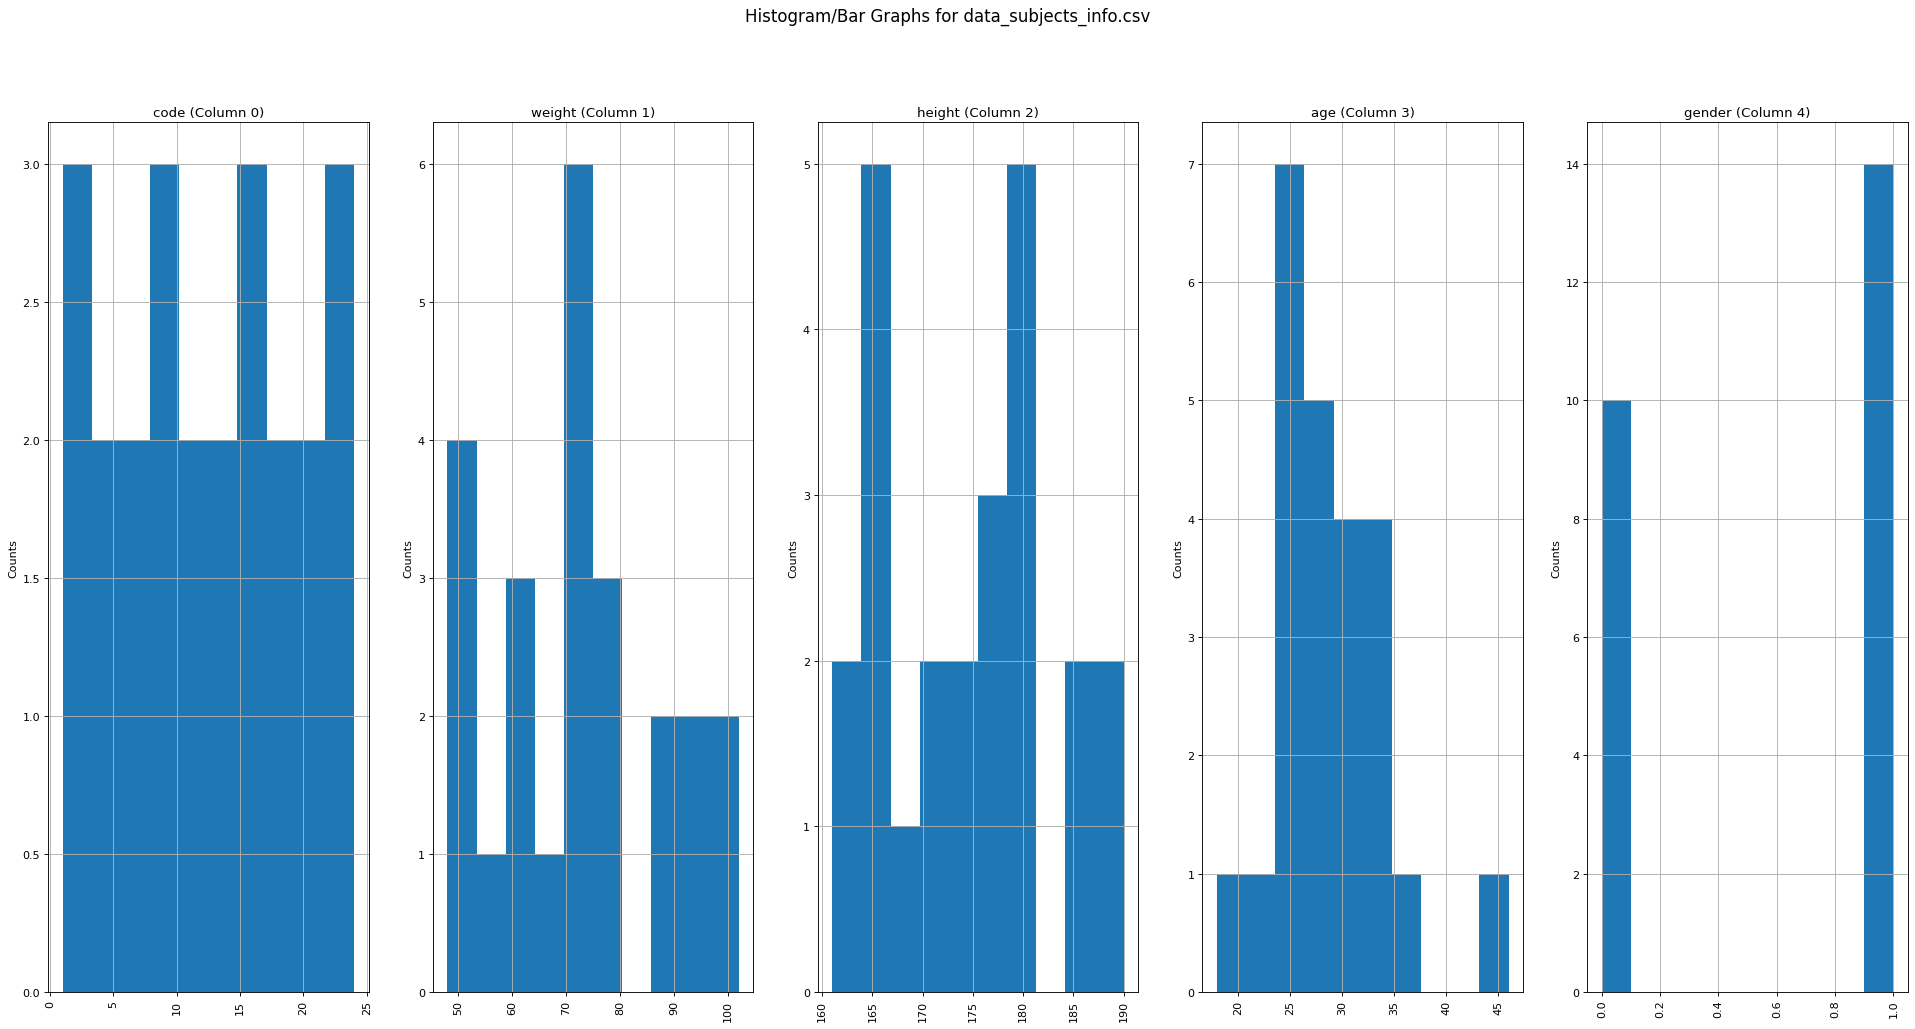

In [ ]:
#@title
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (Column {i})')
    #plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.suptitle(f'Histogram/Bar Graphs for data_subjects_info.csv', fontsize=15)
    plt.show()

plotPerColumnDistribution(df1, 10, 5)

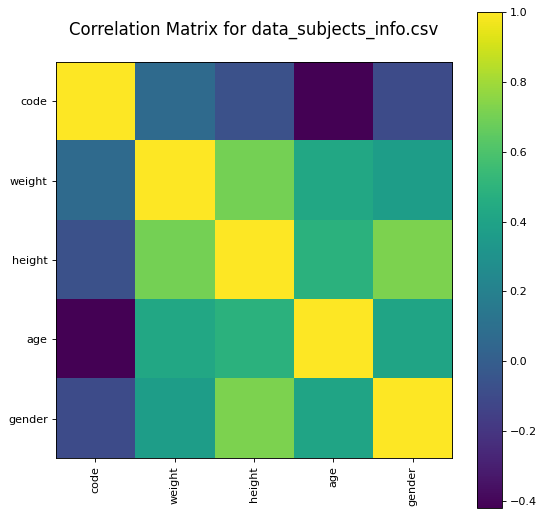

In [ ]:
#@title
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

plotCorrelationMatrix(df1, 8)

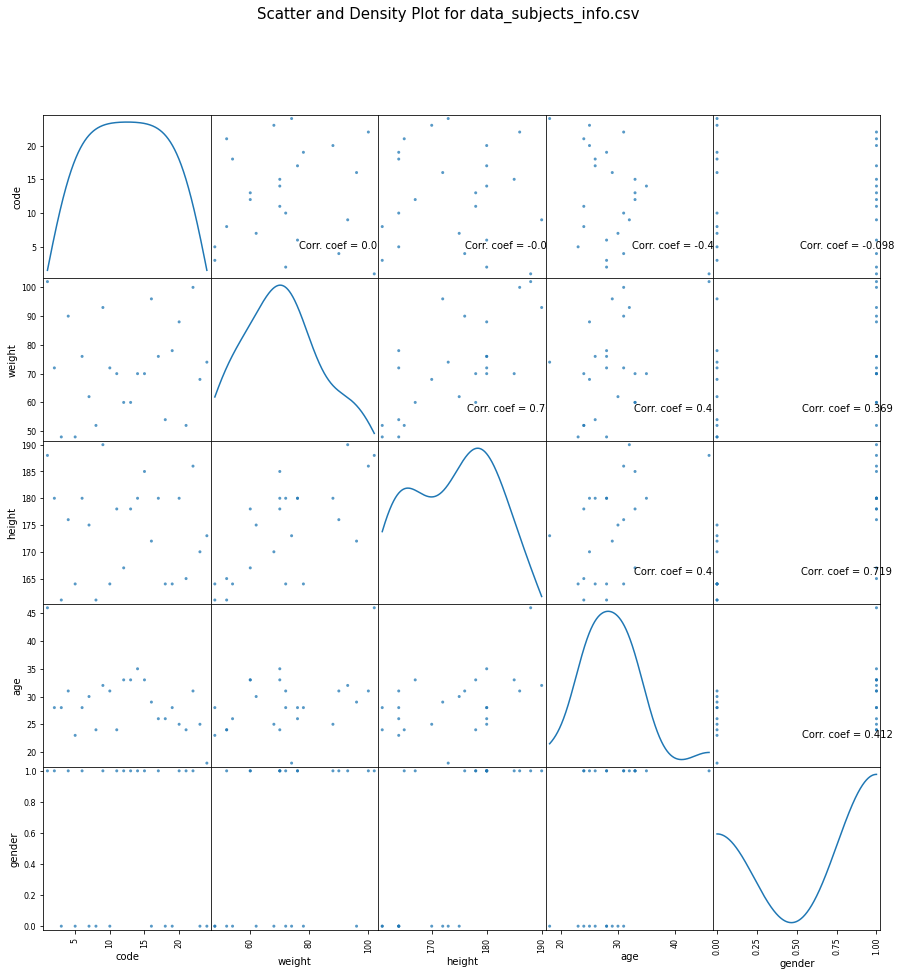

In [ ]:
#@title
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle(f'Scatter and Density Plot for data_subjects_info.csv', fontsize=15)
    #plt.suptitle('Scatter and Density Plot')
    plt.show()

plotScatterMatrix(df1, 15, 10)

In [ ]:
#@title
#set up for machine learning
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import sklearn
import tensorflow as tf

import os
#print(os.listdir("A_DeviceMotion_data/A_DeviceMotion_data"))

# Data Folders:
Folders = glob('A_DeviceMotion_data/A_DeviceMotion_data/*_*')
Folders = [s for s in Folders if "csv" not in s]

Df_all_list = []
Exp = 0
# Segment the data to 400 sampels frames , each one will be a different Expirament
Segment_Size = 400

# Activity types dict:
activity_codes = {'dws':1,'jog':2,'sit':3,'std':4,'ups':5,'wlk':6}        
activity_types = list(activity_codes.keys())

# Load All data:
for j  in Folders:
  Csv = glob(j + '/*' )
  for i in Csv:
    df = pd.read_csv(i)
    df['Activity'] = activity_codes[j[40:43]]
    df['Sub_Num'] = i[len(j)+5:-4]
    df['Exp_num'] = 1
    ExpNum = np.zeros((df.shape[0])) 
    for i in range(0,df.shape[0]-Segment_Size,Segment_Size):
      ExpNum[range(i,i+Segment_Size)] = i/Segment_Size +Exp*100 
    df['Exp_num'] = ExpNum
    #Df_all = pd.concat([Df_all,df])
    Df_all_list.append(df)
    Exp += 1        
Df_all = pd.concat(Df_all_list,axis=0)  
print(f'The data has been loaded.')
print(f'The dimensions of the complete dataset are {Df_all.shape}.')
print(f'The 16 column headers are {Df_all.columns}.')
#check unique values for the participants
#np.unique(Df_all['Sub_Num'])

The data has been loaded.
The dimensions of the complete dataset are (1412865, 16).
The 16 column headers are Index(['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x',
       'rotationRate.y', 'rotationRate.z', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'Activity', 'Sub_Num',
       'Exp_num'],
      dtype='object').


Some participants completed more activities, and for longer, than others.

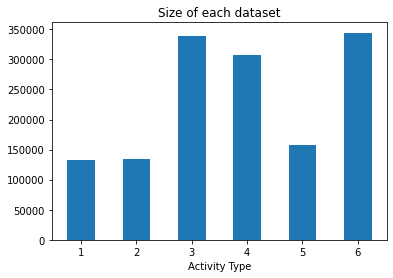

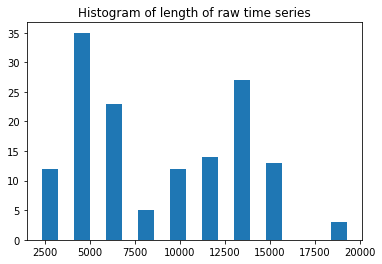

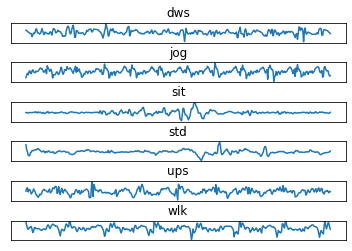

In [ ]:
#@title
### Missing values
##checks = pd.isna(Df_all).sum()
##print(checks)
### class balance
class_counts = list()

for act in activity_types[:1]:
    class_counts.append(Df_all[Df_all['Activity']==activity_codes[act]].count())
plt.figure(1)
plt.title('Size of each dataset')
plt.xlabel('Activity Type')
plt.hist(Df_all['Activity'],bins=range(1,8),rwidth=0.5,align='left')

### Length of time series
series_length = list()
for act in activity_types:
    for sub in range(1,25):
        sub = str(sub)
        series_length.append(Df_all[(Df_all['Sub_Num']==sub) & (Df_all['Activity']==activity_codes[act])].shape[0])
plt.figure(2)
plt.title('Histogram of length of raw time series')
plt.hist(series_length,rwidth=0.5,align='left')

### show the first few records of motion type
plt.figure(3)
colors = ['r','g','b','c','m','y','k']
for act in activity_types:
    plt.subplot('61'+str(activity_codes[act]))
    plt.subplots_adjust(hspace=1.0)
    df = Df_all[(Df_all['Sub_Num']=='1') & (Df_all['Activity']==activity_codes[act])]
    plt.title(act)
    plt.plot(df['userAcceleration.z'][:400])
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels

In [ ]:
#  Calculate features
df_sum = Df_all.groupby('Exp_num', axis=0).mean().reset_index()
df_sum.columns = df_sum.columns.str.replace('.','_sum_')

df_sum_SS = np.power(Df_all.astype(float),2).groupby('Exp_num', axis=0).median().reset_index() 
df_sum_SS.columns = df_sum_SS.columns.str.replace('.','_sumSS_')

df_max = Df_all.groupby('Exp_num', axis=0).max().reset_index()
df_max.columns = df_max.columns.str.replace('.','_max_')

df_min = Df_all.groupby('Exp_num', axis=0).min().reset_index()
df_min.columns = df_min.columns.str.replace('.','_min_')

df_skew = Df_all.groupby('Exp_num', axis=0).skew().reset_index()
df_skew.columns = df_skew.columns.str.replace('.','_skew_')

df_std = Df_all.groupby('Exp_num', axis=0).std().reset_index()
df_std.columns = df_std.columns.str.replace('.','_std_')

Df_Features = pd.concat([ df_max , df_sum[df_sum.columns[2:-2]], 
                         df_min[df_min.columns[2:-2]], df_sum_SS[df_sum_SS.columns[2:-2]], 
                         df_std[df_std.columns[2:-2]], df_skew[df_skew.columns[2:-2]]], axis=1)

X = Df_Features.drop(['Exp_num','Unnamed: 0','Activity','Sub_Num'],axis=1)
Y = Df_Features['Activity']

print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (3359, 70)
Shape of Y: (3359,)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

#### dimension reduction
### use pca to reduce the dimension to 2D directly.
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(1)
colors = ['r','g','b','c','m','y','k']
lw = 2

for color, i, target_name in zip(colors, range(6), activity_types):
    plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Principal Component Analysis')

### sklearn tsne
# sites.google.com/s/1HAV-HEiBhPHLgdh5Ejmu31TrVIQqw9HU/p/1bPpOCDlxW7i5nOpy3bvpnmkqa8Y-SDVa/edit
# Scale data
scl = StandardScaler()
scaled_X = scl.fit_transform(X)

# Reduce dimensions before feeding into tsne
pca = PCA(n_components=0.9, random_state=3)
pca_transformed = pca.fit_transform(scaled_X)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(pca_transformed)

plt.figure(2)
for color, i, target_name in zip(colors, range(6), activity_types):
    plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('TSNE')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

IndexError: ignored

<Figure size 432x288 with 0 Axes>

###Hierachical clustering with dynamic time wrapping

Using the methods provided by library "dtaidistance.", 400 datapoints of each motion type are segmented and similiarity between each segment is calculated by dynamic time wrapping.


In [ ]:
series_list = list()
labels_list = list()
for act in activity_types:

    df = Df_all[(Df_all['Sub_Num']=='1') & (Df_all['Activity']==activity_codes[act])]
    series_list.append(df['userAcceleration.z'][:400])
    labels_list.extend([act])

print(labels_list)

['dws', 'jog', 'sit', 'std', 'ups', 'wlk']


In [ ]:
pip install dtaidistance

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcece26bad0>,
       dtype=object))

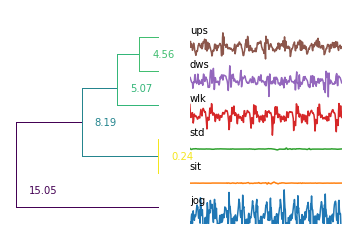

In [ ]:
import matplotlib.pyplot as plt
from dtaidistance import dtw, clustering
import numpy as np

series = np.array(series_list)
ds = dtw.distance_matrix_fast(series)

model = clustering.LinkageTree(dtw.distance_matrix_fast, {})
model.fit(series)
model.plot(show_ts_label=labels_list,
           show_tr_label=True)

Based on hierachical clustering, 'dws', 'ups', 'wlk' are similar to each other, 'sit' and 'std' are similair, and 'jog' is distinctive from the other five.

Train multi-layer perceptron classifier

In [ ]:
import itertools

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils

In [ ]:
#### Construct neural architecture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])

In [ ]:
# One-hot encoding
Y = to_categorical(Y)
print(Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

(3359, 7)


In [ ]:
#### Check model performance
### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

32/32 [==============================] - 0s 1ms/step - loss: 0.0128 - categorical_accuracy: 0.9881
keras test accuracy score: 0.988095223903656


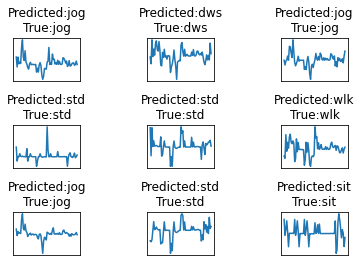

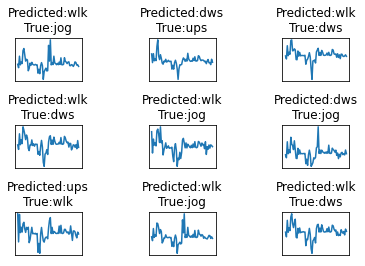

In [ ]:
# One-hot decoding
y_pred = np.argmax(model.predict(X_test),axis=1)
y_test = np.argmax(Y_test,axis=1)
#print(y_pred,y_test)

correct = np.nonzero(y_pred==y_test)[0]
incorrect = np.nonzero(y_pred!=y_test)[0]
#print(correct)

### Check the correctly-predicted samples
plt.figure(1)
for i, cor in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace=1.0,wspace=1.0)
    plt.plot(X_test.iloc[cor,:])
    plt.title("Predicted:{}\nTrue:{}".format(activity_types[y_pred[cor]-1], 
                                              activity_types[y_test[cor]-1]))
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    #plt.tight_layout()
plt.show()
### Check the incorrectly-predicted samples
plt.figure(2)
for i, cor in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace=1.0,wspace=1.0)
    plt.plot(X_test.iloc[cor,:])
    plt.title("Predicted:{}\nTrue:{}".format(activity_types[y_pred[cor]-1], 
                                              activity_types[y_test[cor]-1]))
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    #plt.tight_layout()
plt.show()

Confusion matrix, without normalization
[[ 79   0   0   0   0   4]
 [  1 101   0   0   0   4]
 [  0   0 264   0   0   0]
 [  0   0   0 223   0   0]
 [  1   0   0   0 100   1]
 [  0   0   0   0   1 229]]


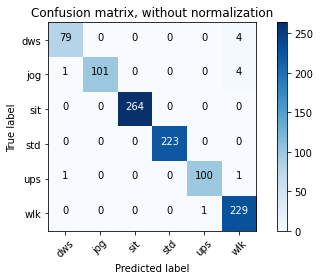

In [ ]:
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Confusion matrix, without normalization')

'ups' has the highest misclassification rate, and is clasified as 'dws' and 'wlk'

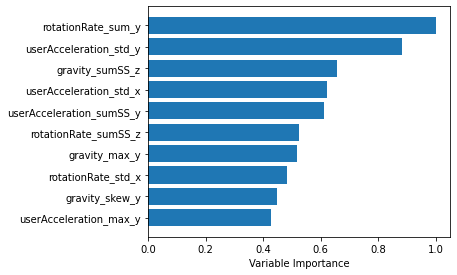

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)
clf1.fit(X_train, Y_train)
featureImportance = clf1.feature_importances_

# normalize by max importance
featureImportance = featureImportance / featureImportance.max()
feature_names = X.columns
idxSorted = np.argsort(featureImportance)[-10:]
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos, featureImportance[idxSorted], align='center')
plt.yticks(barPos, feature_names[idxSorted])
plt.xlabel('Variable Importance')
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
plt.show()


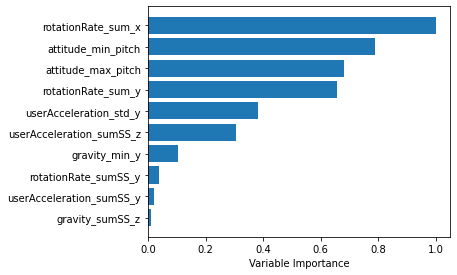

In [ ]:
# Need to one-hot decode before feeding into GBM
y_train = np.argmax(Y_train,axis=1)
clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)
clf2.fit(X_train, y_train)
featureImportance = clf2.feature_importances_


# normalize by max importance
featureImportance = featureImportance / featureImportance.max()
feature_names = X.columns
idxSorted = np.argsort(featureImportance)[-10:]
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos, featureImportance[idxSorted], align='center')
plt.yticks(barPos, feature_names[idxSorted])
plt.xlabel('Variable Importance')
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
plt.show()

In [ ]:
### One-hot encoding for tree classifier
print(Y_train.shape)

(2351, 7)


In [ ]:
# Let target label become subjects
Y1 = Df_Features['Sub_Num']


In [ ]:
#### Construct neural Architeture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(25, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])

In [ ]:
# One-hot encoding

y1 = to_categorical(Y1)
print(Y1.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, y1, test_size=0.3, random_state=0)

history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

(3359,)
32/32 [==============================] - 0s 1ms/step - loss: 0.0599 - categorical_accuracy: 0.8185
keras test accuracy score: 0.8184523582458496


In [ ]:
for i in range(1,7):
    df = Df_Features[Df_Features['Activity']==i]
    x = df.drop(['Exp_num','Unnamed: 0','Activity','Sub_Num'],axis=1)
    y = df['Sub_Num']
    y = to_categorical(y)
    
    #### Construct neural Architeture
    input_dim = x.shape[1]
    input_img = Input(shape=(input_dim,))
    d = Dense(50, activation='relu')(input_img)
    d = Dense(20, activation='relu')(d)
    output = Dense(25, activation='softmax', kernel_regularizer=l2(0.01))(d)
    model = Model(input_img,output)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['categorical_accuracy'])
    
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

    history = model.fit(X_train, Y_train,
                    epochs=1000,
                    batch_size=100,
                    shuffle=True,
                    verbose=0,
                    validation_data=[X_test,Y_test])

    ### Overall test accuracy
    score = model.evaluate(X_test, Y_test)
    print('Activity type:', activity_types[i-1])
    print('keras test accuracy score:', score[1])

3/3 [==============================] - 0s 4ms/step - loss: 0.0741 - categorical_accuracy: 0.7865
Activity type: dws
keras test accuracy score: 0.7865168452262878
3/3 [==============================] - 0s 4ms/step - loss: 0.0384 - categorical_accuracy: 0.9468
Activity type: jog
keras test accuracy score: 0.9468085169792175
8/8 [==============================] - 0s 3ms/step - loss: 0.0320 - categorical_accuracy: 0.9069
Activity type: sit
keras test accuracy score: 0.9068825840950012
7/7 [==============================] - 0s 3ms/step - loss: 0.0915 - categorical_accuracy: 0.6786
Activity type: std
keras test accuracy score: 0.6785714030265808
4/4 [==============================] - 0s 3ms/step - loss: 0.0511 - categorical_accuracy: 0.8519
Activity type: ups
keras test accuracy score: 0.8518518805503845
8/8 [==============================] - 0s 2ms/step - loss: 0.0242 - categorical_accuracy: 0.9438
Activity type: wlk
keras test accuracy score: 0.9437751173973083


Overfitting??

on gender:
1 for male or female??

In [ ]:
mapping = {
    '1': 1,
    '2': 1,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':0,
    '8':0,
    '9':1,
    '10':0,
    '11':1,
    '12':1,
    '13':1,
    '14':1,
    '15':1,
    '16':0,
    '17':1,
    '18':0,
    '19':0,
    '20':1,
    '21':1,
    '22':1,
    '23':0,
    '24':0

}

In [ ]:
# Create gender labels
Y2 = [mapping[i] for i in Df_Features['Sub_Num']]

In [ ]:
y2 = to_categorical(Y2)

X_train, X_test, Y_train, Y_test = train_test_split(X, y2, test_size=0.3, random_state=0)
print('The number of training samples:',X_train.shape[0])
print('The number of test samples:',X_test.shape[0])


#### Construct neural Architeture for baseline model
input_dim = x.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])
    
history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

The number of training samples: 2351
The number of test samples: 1008
32/32 [==============================] - 0s 1ms/step - loss: 0.6355 - categorical_accuracy: 0.9038
keras test accuracy score: 0.903769850730896


on weight:
The subjects above the average weight 72.125 are labeled as 1; 0 for below average.

In [ ]:
mapping = {
    '1': 1,
    '2': 0,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':0,
    '8':0,
    '9':1,
    '10':0,
    '11':0,
    '12':0,
    '13':0,
    '14':0,
    '15':0,
    '16':1,
    '17':1,
    '18':0,
    '19':1,
    '20':1,
    '21':0,
    '22':1,
    '23':0,
    '24':1

}

In [ ]:
# Create gender labels
Y3 = [mapping[i] for i in Df_Features['Sub_Num']]

In [ ]:
y3 = to_categorical(Y3)

X_train, X_test, Y_train, Y_test = train_test_split(X, y3, test_size=0.3, random_state=0)
print('The number of training samples:',X_train.shape[0])
print('The number of test samples:',X_test.shape[0])


#### Construct neural Architeture for baseline model
input_dim = x.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])
    
history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

The number of training samples: 2351
The number of test samples: 1008
32/32 [==============================] - 0s 1ms/step - loss: 0.8245 - categorical_accuracy: 0.8770
keras test accuracy score: 0.8769841194152832


In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5
import re, time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Tensorflow version 2.7.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of accelerators:  1


In [ ]:
X

,attitude_max_roll,attitude_max_pitch,attitude_max_yaw,gravity_max_x,gravity_max_y,gravity_max_z,rotationRate_max_x,rotationRate_max_y,rotationRate_max_z,userAcceleration_max_x,userAcceleration_max_y,userAcceleration_max_z,attitude_sum_roll,attitude_sum_pitch,attitude_sum_yaw,gravity_sum_x,gravity_sum_y,gravity_sum_z,rotationRate_sum_x,rotationRate_sum_y,rotationRate_sum_z,userAcceleration_sum_x,userAcceleration_sum_y,attitude_min_roll,attitude_min_pitch,attitude_min_yaw,gravity_min_x,gravity_min_y,gravity_min_z,rotationRate_min_x,rotationRate_min_y,rotationRate_min_z,userAcceleration_min_x,userAcceleration_min_y,userAcceleration_min_z,attitude_sumSS_roll,attitude_sumSS_pitch,attitude_sumSS_yaw,gravity_sumSS_x,gravity_sumSS_y,gravity_sumSS_z,rotationRate_sumSS_x,rotationRate_sumSS_y,rotationRate_sumSS_z,userAcceleration_sumSS_x,userAcceleration_sumSS_y,userAcceleration_sumSS_z,attitude_std_roll,attitude_std_pitch,attitude_std_yaw,gravity_std_x,gravity_std_y,gravity_std_z,rotationRate_std_x,rotationRate_std_y,rotationRate_std_z,userAcceleration_std_x,userAcceleration_std_y,attitude_skew_roll,attitude_skew_pitch,attitude_skew_yaw,gravity_skew_x,gravity_skew_y,gravity_skew_z,rotationRate_skew_x,rotationRate_skew_y,rotationRate_skew_z,userAcceleration_skew_x,userAcceleration_skew_y,userAcceleration_skew_z
0,3.141433,1.474256,3.141409,0.999974,0.999999,0.969201,9.687545,13.542882,10.450259,6.649587,7.026950,8.125357,-0.082813,-1.036847,-0.062945,0.059124,0.793986,-0.143954,0.011283,0.012683,0.017504,-0.003509,0.061862,-3.141565,-1.569648,-3.141543,-0.998956,-0.995344,-0.999640,-12.325145,-14.677776,-9.794188,-5.431018,-3.376496,-7.256814,1.185540,1.435535,1.743285,0.043163,0.867437,0.055567,0.415061,0.265231,0.110969,0.013676,0.030451,0.018598,1.538280,0.439686,1.734914,0.336979,0.297174,0.378799,1.486216,1.456419,0.984142,0.398738,0.615276,-0.193742,1.509706,0.099631,0.194793,-2.215141,-0.009689,0.086716,0.071028,0.088138,0.438031,1.862259,-0.296717
1,2.127248,-0.478444,3.134637,0.647437,0.888436,0.340222,5.548653,6.045178,2.445575,0.750258,2.060059,0.856494,1.206780,-0.854934,0.279980,0.516537,0.747966,-0.235020,0.376151,0.538444,0.029213,-0.014734,0.063892,0.314479,-1.093927,-3.102768,0.258261,0.460398,-0.809544,-2.494352,-6.253131,-2.098139,-1.240485,-0.534099,-0.952085,1.451696,0.775366,0.276548,0.281008,0.594577,0.074161,0.684896,1.934902,0.164292,0.026579,0.036037,0.048955,0.505735,0.134329,1.265346,0.083686,0.092758,0.321234,1.487910,2.087948,0.714581,0.276365,0.341630,0.053774,0.755847,0.203544,-1.029170,-1.066388,-0.064479,0.688102,-0.333474,0.685259,-0.383747,1.503162,-0.251796
2,3.097633,-0.636667,3.116382,0.630658,0.999935,0.285952,3.286810,4.422333,5.057590,0.769034,2.452043,0.518184,0.336312,-1.277441,-0.699354,0.176405,0.938721,-0.037939,0.073844,0.403046,0.028331,-0.010526,0.029481,-3.134481,-1.559430,-3.139713,-0.218073,0.594518,-0.524758,-4.358622,-2.428462,-4.514757,-0.947973,-0.908603,-0.724385,2.305744,1.751487,0.590713,0.033516,0.940051,0.016707,0.691784,0.663059,1.048474,0.040190,0.049811,0.014851,1.809132,0.200188,1.540742,0.217700,0.077503,0.181811,1.186589,1.165770,1.519477,0.294752,0.439534,-0.776187,0.947956,-0.155795,0.122552,-2.098045,-0.454919,0.262528,0.431674,0.113761,-0.055266,2.001415,-0.382062
3,2.957231,-0.653995,3.030220,0.678151,0.999924,0.179409,3.182257,3.683911,4.416698,1.183077,3.677903,0.691172,0.807545,-1.240234,0.430995,0.252295,0.917678,-0.106767,0.072925,0.359395,-0.065753,-0.065083,0.042829,-2.958702,-1.558442,-3.122079,-0.111655,0.608362,-0.439458,-4.071569,-3.588117,-4.253582,-0.753068,-0.802481,-0.797054,1.500043,1.772460,0.603672,0.047761,0.943747,0.013621,0.631999,0.562600,0.843104,0.032102,0.042747,0.014350,1.347993,0.248813,1.331610,0.218458,0.104642,0.156007,1.157444,1.125058,1.427922,0.271778,0.492715,-1.759602,0.809439,-0.898290,0.334104,-1.427664,-0.295398,0.193239,-0.039761,0.168088,0.048561,3.445093,-0.427650
4,3.133464,-0.576036,1.672870,0.731840,0.999287,0.285500,3.12

In [ ]:
# Split our data
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
y.format(shape)

AttributeError: ignored

In [ ]:
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, y_train)
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, y_train)


In [ ]:
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, y_train)
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, y_train)

In [ ]:
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, y_train)

In [ ]:
print('linearSVM accuracy:',accuracy_score(y_test, SVM_linear.predict(X_test)))
print('rbf_SVM accuracy:',accuracy_score(y_test, SVM_rbf.predict(X_test)))
print('logistic_regression (L1) accuracy:',accuracy_score(y_test, LR_L1.predict(X_test)))
print('logistic_regression (L2) accuracy:',accuracy_score(y_test, LR_L2.predict(X_test)))

In [ ]:
print('decision tree accuracy:',accuracy_score(y_test, DT.predict(X_test)))
print('Random Forest accuracy:',accuracy_score(y_test, RF.predict(X_test)))


decision tree accuracy: 0.8974358974358975
Random Forest accuracy: 0.9157509157509157


In [ ]:
# this code is based on Bakharia'blog "Visualising Top Features in Linear SVM with Scikit Learn and Matplotlib"
# https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, clf_id, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
    plt.figure(figsize=(15, 5))
    plt.title(clf_id)
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    

decision tree accuracy: 0.8974358974358975


<Figure size 432x288 with 0 Axes>

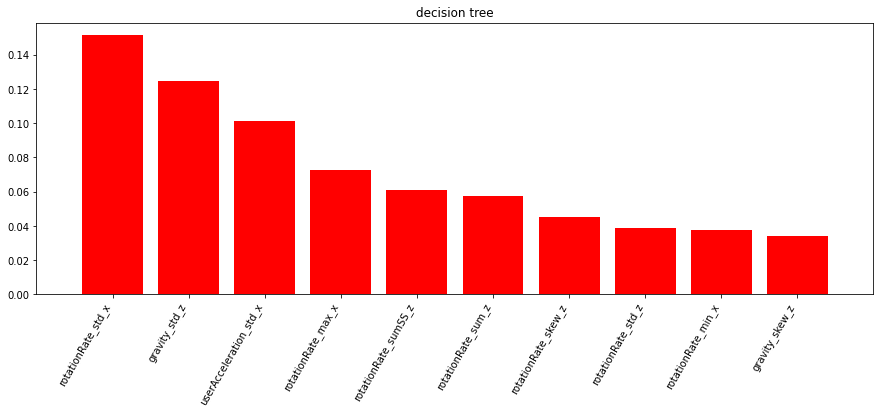

In [ ]:
feature_names = X.columns
X_names = feature_names


# for tree-based classifier's feature importance plotting
def plot_keyFeat_trees(classifier, feature_names, clf_id, top_features=10):
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    indices_vis = indices[:top_features]
    
    plt.figure()
    plt.figure(figsize=(15, 5))
    plt.title(clf_id)
    plt.bar(range(top_features), importances[indices_vis],
       color="r", align="center")
    plt.xticks(range(top_features), indices)
    plt.xlim([-1, top_features])
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, top_features), feature_names[indices_vis], rotation=60, ha='right')
    plt.show()

print('decision tree accuracy:',accuracy_score(y_test, DT.predict(X_test)))
plot_keyFeat_trees(DT, X_names, 'decision tree', top_features=10)

Random Forest accuracy: 0.9157509157509157


<Figure size 432x288 with 0 Axes>

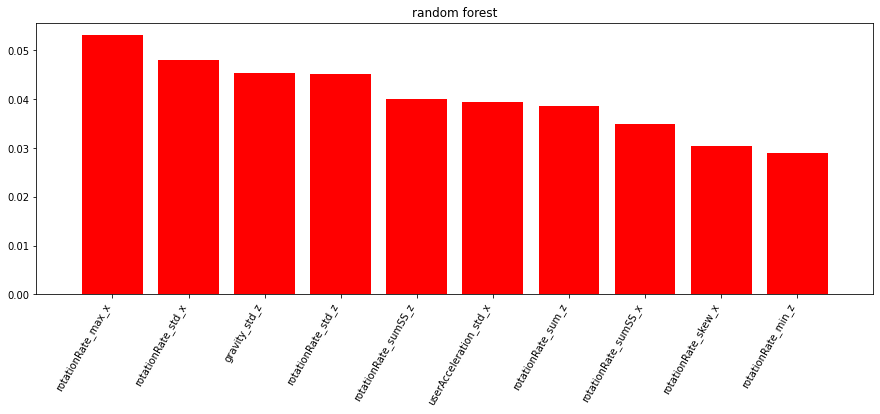

In [ ]:
print('Random Forest accuracy:',accuracy_score(y_test, RF.predict(X_test)))
plot_keyFeat_trees(RF, X_names, 'random forest', top_features=10)